## Spain GBIF EDA (download-zip based, self-contained)

This notebook performs EDA on **Spain-scale GBIF occurrence exports** you previously generated as GBIF **download jobs** (ZIP files).

It is designed to run **standalone** (no dependencies on other notebooks).

### What it does
- Unzips all `*.zip` in `data/gbif_downloads/`
- Converts the exported tables into a cached **Parquet dataset** (partitioned; scalable)
- EDA:
  - **Issues**: per-year share of records with any issues + top issue codes
  - **Completeness**: per-year per-column non-null coverage
  - **Counts over time**: occurrences per year

### Assumptions
- Exports are GBIF occurrence downloads in **SIMPLE_CSV** or **DWCA** format.
- Large volumes: this notebook avoids loading everything into RAM at once.


In [2]:
from __future__ import annotations

import re
import zipfile
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Optional (nicer plots)
try:
    import seaborn as sns

    sns.set_theme(style="whitegrid")
except Exception:
    sns = None


DATA_DIR = Path("data")
DOWNLOADS_DIR = DATA_DIR / "gbif_downloads"
EXTRACT_DIR = DOWNLOADS_DIR / "_extracted"
CACHE_DIR = DATA_DIR / "cache"
PARQUET_DS_DIR = CACHE_DIR / "spain_gbif_occurrence_parquet"

# If True: re-extract zips even if a folder for that key exists
FORCE_REEXTRACT = False

# If True: rebuild parquet dataset from scratch
FORCE_REBUILD_PARQUET = False

# Parquet write settings
PARQUET_COMPRESSION = "zstd"

print("Downloads dir:", DOWNLOADS_DIR)
print("Extract dir:", EXTRACT_DIR)
print("Parquet dataset dir:", PARQUET_DS_DIR)

Downloads dir: data/gbif_downloads
Extract dir: data/gbif_downloads/_extracted
Parquet dataset dir: data/cache/spain_gbif_occurrence_parquet


In [3]:
def list_download_zips(downloads_dir: Path) -> list[Path]:
    zips = sorted(downloads_dir.glob("*.zip"))
    if not zips:
        raise FileNotFoundError(f"No .zip files found in {downloads_dir}")
    return zips


def download_key_from_filename(p: Path) -> str:
    # filenames look like 0003432-260208012135463.zip
    m = re.match(r"^(\d+-\d+)\.zip$", p.name)
    return m.group(1) if m else p.stem


def ensure_unzipped(zip_path: Path, extract_root: Path, force: bool = False) -> Path:
    key = download_key_from_filename(zip_path)
    out_dir = extract_root / key
    if out_dir.exists() and not force:
        return out_dir

    out_dir.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(out_dir)
    return out_dir


zips = list_download_zips(DOWNLOADS_DIR)
print("Found ZIPs:", len(zips))
print("Example:", zips[0])

EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
extracted_dirs = [ensure_unzipped(z, EXTRACT_DIR, force=FORCE_REEXTRACT) for z in zips]
print("Extracted dirs:", len(extracted_dirs))
print("Example extracted dir:", extracted_dirs[0])

Found ZIPs: 10
Example: data/gbif_downloads/0003432-260208012135463.zip
Extracted dirs: 10
Example extracted dir: data/gbif_downloads/_extracted/0003432-260208012135463


In [3]:
def find_occurrence_table(extracted_dir: Path) -> Path:
    """Return a path to the main occurrence table inside an extracted GBIF export.

    Supports:
    - SIMPLE_CSV: a single CSV named like <download_key>.csv
    - DWCA: occurrence.txt inside the DwC-A
    """
    # DWCA typical layout
    dwca_occ = extracted_dir / "occurrence.txt"
    if dwca_occ.exists():
        return dwca_occ

    # Some exports include occurrence.csv
    for name in ("occurrence.csv", "occurrence.tsv"):
        p = extracted_dir / name
        if p.exists():
            return p

    # SIMPLE_CSV: usually one CSV file (often named with the download key)
    csvs = list(extracted_dir.glob("*.csv"))
    if len(csvs) == 1:
        return csvs[0]

    # Fallback: pick the largest CSV/TXT
    candidates = list(extracted_dir.glob("*.csv")) + list(extracted_dir.glob("*.txt"))
    if not candidates:
        raise FileNotFoundError(f"No occurrence table found in {extracted_dir}")

    candidates = sorted(candidates, key=lambda p: p.stat().st_size, reverse=True)
    return candidates[0]


def guess_sep(path: Path) -> str:
    return "\t"
    # occurrence.txt in DWCA is tab-separated
    # if path.suffix.lower() == ".txt":
    #     return "\t"
    # return ","


def read_occurrence_in_chunks(path: Path, chunksize: int = 200_000):
    sep = guess_sep(path)
    # use dtype_backend="pyarrow" for memory efficiency (pandas >= 2)
    return pd.read_csv(
        path,
        sep=sep,
        chunksize=chunksize,
        low_memory=False,
        dtype_backend="pyarrow",
        on_bad_lines="skip",
    )


# Inspect one extracted export
sample_dir = extracted_dirs[0]
occ_path = find_occurrence_table(sample_dir)
print("Sample occurrence table:", occ_path)

# Peek at columns
chunk0 = next(iter(read_occurrence_in_chunks(occ_path, chunksize=50_000)))
print("Columns:", len(chunk0.columns))
print("Key columns present:", [c for c in ["countryCode", "year", "eventDate", "issues", "species", "scientificName"] if c in chunk0.columns])
display(chunk0.head(3))

Sample occurrence table: data/gbif_downloads/_extracted/0003432-260208012135463/0003432-260208012135463.csv
Columns: 50
Key columns present: ['countryCode', 'year', 'eventDate', 'species', 'scientificName']


,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
0,5862825616,040c5662-da76-4782-a48e-cdea1892d14c,GBAAW37590-24,Animalia,Arthropoda,Insecta,Hymenoptera,Aphelinidae,<NA>,<NA>,...,<NA>,<NA>,CC_BY_4_0,<NA>,<NA>,None,<NA>,2026-02-03T12:08:22.382Z,<NA>,COUNTRY_DERIVED_FROM_COORDINATES;GEODETIC_DATU...
1,5859977656,040c5662-da76-4782-a48e-cdea1892d14c,MUSBA3957-25,Animalia,Arthropoda,Arachnida,Araneae,Linyphiidae,Lessertia,Lessertia barbara,...,Marc Domenech,<NA>,CC_BY_4_0,<NA>,Toni Perez,None,<NA>,2026-02-03T12:08:03.553Z,<NA>,COUNTRY_DERIVED_FROM_COORDINATES;GEODETIC_DATU...
2,6116970252,040c5662-da76-4782-a48e-cdea1892d14c,UNAFI038-25,Animalia,Chordata,<NA>,Scorpaeniformes,Dactylopteridae,Dactylopterus,Dactylopterus volitans,...,Rafael Banon,<NA>,CC_BY_4_0,<NA>,Biel Pomar,None,<NA>,2026-02-03T12:08:27.670Z,<NA>,COUNTRY_DERIVED_FROM_COORDINATES;GEODETIC_DATU...


In [6]:
def ensure_parquet_dataset(
    extracted_dirs: list[Path],
    out_dir: Path,
    force: bool = False,
    chunksize: int = 1_000_000,
) -> Path:
    """Build a Parquet dataset from many GBIF export files.

    Output layout:
    - out_dir/year=YYYY/part-....parquet

    Notes:
    - This avoids one giant Parquet file.
    - We only require a usable `year` column. If missing, we try to derive it.
    """
    if out_dir.exists() and not force:
        print("Parquet dataset already exists:", out_dir)
        return out_dir

    if force and out_dir.exists():
        # wipe existing dataset
        for p in out_dir.rglob("*"):
            if p.is_file():
                p.unlink()
        # remove empty dirs bottom-up
        for p in sorted(out_dir.rglob("*"), reverse=True):
            if p.is_dir():
                try:
                    p.rmdir()
                except OSError:
                    pass

    out_dir.mkdir(parents=True, exist_ok=True)

    n_files = 0
    n_rows = 0

    for d in extracted_dirs:
        n_files += 1
        occ_file = find_occurrence_table(d)
        key = d.name  # download key

        print(f"[{n_files}/{len(extracted_dirs)}] Reading {occ_file.name} ({key})")

        for i, chunk in enumerate(read_occurrence_in_chunks(occ_file, chunksize=chunksize)):
            # Normalize column names a bit (GBIF uses e.g. countryCode, year)
            if "year" not in chunk.columns:
                # Try derive from eventDate if present
                if "eventDate" in chunk.columns:
                    dt = pd.to_datetime(chunk["eventDate"], errors="coerce")
                    chunk["year"] = dt.dt.year
                else:
                    chunk["year"] = pd.NA

            # Attach the download key for provenance
            chunk["download_key"] = key

            # Keep year as integer where possible
            chunk["year"] = pd.to_numeric(chunk["year"], errors="coerce").astype("Int64")

            # Drop records without year (can’t be partitioned)
            chunk = chunk[chunk["year"].notna()].copy()

            # Write per-year partitions
            # (pandas will create year=<value> directories)
            chunk.to_parquet(
                out_dir,
                index=False,
                partition_cols=["year"],
                compression=PARQUET_COMPRESSION,
                engine="pyarrow",
            )

            n_rows += len(chunk)
            if i == 0:
                print("  wrote first chunk rows:", len(chunk), "cols:", len(chunk.columns))

    print("Done. Rows written (after dropping missing year):", n_rows)
    return out_dir


PARQUET_DS_DIR = ensure_parquet_dataset(
    extracted_dirs,
    PARQUET_DS_DIR,
    force=FORCE_REBUILD_PARQUET,
    chunksize=1_000_000,
)

print("Parquet dataset ready:", PARQUET_DS_DIR)

[1/10] Reading 0003432-260208012135463.csv (0003432-260208012135463)
  wrote first chunk rows: 1000000 cols: 51
[2/10] Reading 0003433-260208012135463.csv (0003433-260208012135463)
  wrote first chunk rows: 24341 cols: 51
[3/10] Reading 0003468-260208012135463.csv (0003468-260208012135463)
  wrote first chunk rows: 849908 cols: 51
[4/10] Reading 0003469-260208012135463.csv (0003469-260208012135463)
  wrote first chunk rows: 866900 cols: 51
[5/10] Reading 0003502-260208012135463.csv (0003502-260208012135463)
  wrote first chunk rows: 1000000 cols: 51
[6/10] Reading 0003567-260208012135463.csv (0003567-260208012135463)
  wrote first chunk rows: 1000000 cols: 51
[7/10] Reading 0003568-260208012135463.csv (0003568-260208012135463)
  wrote first chunk rows: 1000000 cols: 51
[8/10] Reading 0003569-260208012135463.csv (0003569-260208012135463)
  wrote first chunk rows: 1000000 cols: 51
[9/10] Reading 0003650-260208012135463.csv (0003650-260208012135463)
  wrote first chunk rows: 1000000 cols:

In [5]:
# Load only the last years (2020-2026 inclusive)
# Robust approach: read only the partition folders year=YYYY instead of using `filters=`
# (some pandas/pyarrow combos error on dictionary-encoded partition columns).

YEAR_MIN = 2020
YEAR_MAX = 2026

# Parquet dataset is partitioned like: data/cache/.../year=2024/part-....parquet
partition_dirs = [PARQUET_DS_DIR / f"year={y}" for y in range(YEAR_MIN, YEAR_MAX + 1)]
partition_dirs = [p for p in partition_dirs if p.exists()]

if not partition_dirs:
    raise FileNotFoundError(
        f"No year partitions found for {YEAR_MIN}-{YEAR_MAX} under {PARQUET_DS_DIR}. "
        f"Check dataset path or rebuild parquet."
    )

print("Reading partitions:")
for p in partition_dirs:
    print("-", p)

# Expand partition dirs into a list of parquet files (some versions don't accept directories here)
parquet_files: list[Path] = []
for d in partition_dirs:
    parquet_files.extend(sorted(d.rglob("*.parquet")))

if not parquet_files:
    raise FileNotFoundError(f"No parquet files found under: {partition_dirs}")

print("Parquet files:", len(parquet_files))
print("Example file:", parquet_files[0])

# Quick size estimate using Parquet metadata (no full read)
import pyarrow.parquet as pq

# Build an index of parquet files with `year` attached once (so we don't re-derive it in every cell)
rows = []
for f in parquet_files:
    year = int(f.parent.name.split("=")[1])  # parent folder is year=YYYY
    nrows = pq.ParquetFile(f).metadata.num_rows
    rows.append({"year": year, "path": str(f), "num_rows": int(nrows)})

files_index = pd.DataFrame(rows).sort_values(["year", "path"]).reset_index(drop=True)

# Aggregate rows by year once from the file index
by_year_meta = (
    files_index.groupby("year", as_index=False)["num_rows"]
    .sum()
    .rename(columns={"num_rows": "records"})
    .sort_values("year")
)
print("Rows by year (from parquet metadata):")
display(by_year_meta)

# Show a small sample by reading a single file (safe) and attach year immediately
sample_year = int(files_index.iloc[0]["year"])
sample = pd.read_parquet(files_index.iloc[0]["path"], engine="pyarrow")
if "year" not in sample.columns:
    sample["year"] = sample_year

print("Sample year:", sample_year)
print("Sample rows:", len(sample))
print("Sample columns:", len(sample.columns))
print("Example columns:", list(sample.columns))
display(sample.head(5))

Reading partitions:
- data/cache/spain_gbif_occurrence_parquet/year=2021
- data/cache/spain_gbif_occurrence_parquet/year=2022
- data/cache/spain_gbif_occurrence_parquet/year=2023
- data/cache/spain_gbif_occurrence_parquet/year=2024
- data/cache/spain_gbif_occurrence_parquet/year=2025
- data/cache/spain_gbif_occurrence_parquet/year=2026
Parquet files: 33
Example file: data/cache/spain_gbif_occurrence_parquet/year=2021/292be9f1d080496eafae96f939f6d554-0.parquet
Rows by year (from parquet metadata):


,year,records
0,2021,6335175
1,2022,6790136
2,2023,7022640
3,2024,7413297
4,2025,1038958
5,2026,24341


Sample year: 2021
Sample rows: 1000000
Sample columns: 51
Example columns: ['gbifID', 'datasetKey', 'occurrenceID', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'infraspecificEpithet', 'taxonRank', 'scientificName', 'verbatimScientificName', 'verbatimScientificNameAuthorship', 'countryCode', 'locality', 'stateProvince', 'occurrenceStatus', 'individualCount', 'publishingOrgKey', 'decimalLatitude', 'decimalLongitude', 'coordinateUncertaintyInMeters', 'coordinatePrecision', 'elevation', 'elevationAccuracy', 'depth', 'depthAccuracy', 'eventDate', 'day', 'month', 'taxonKey', 'speciesKey', 'basisOfRecord', 'institutionCode', 'collectionCode', 'catalogNumber', 'recordNumber', 'identifiedBy', 'dateIdentified', 'license', 'rightsHolder', 'recordedBy', 'typeStatus', 'establishmentMeans', 'lastInterpreted', 'mediaType', 'issue', 'download_key', 'year']


,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue,download_key,year
0,5527086344,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,URN:catalog:CLO:EBIRD:OBS1081030743,Animalia,Chordata,Aves,Passeriformes,Muscicapidae,Saxicola,Saxicola rubicola,...,CC_BY_4_0,<NA>,obsr653048,<NA>,None,2025-11-07T06:17:20.731Z,None,CONTINENT_DERIVED_FROM_COORDINATES;TAXON_CONCE...,0003567-260208012135463,2021
1,5617021140,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,URN:catalog:CLO:EBIRD:OBS1121624755,Animalia,Chordata,Aves,Passeriformes,Alaudidae,Galerida,Galerida theklae,...,CC_BY_4_0,<NA>,obsr829896,<NA>,None,2025-11-07T06:01:05.315Z,None,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,0003567-260208012135463,2021
2,5383152891,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,URN:catalog:CLO:EBIRD:OBS1224412230,Animalia,Chordata,Aves,Pelecaniformes,Ardeidae,Ardea,Ardea alba,...,CC_BY_4_0,<NA>,obsr1015092,<NA>,None,2025-11-07T06:18:08.364Z,None,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,0003567-260208012135463,2021
3,3689453898,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,URN:catalog:CLO:EBIRD:OBS1174269945,Animalia,Chordata,Aves,Passeriformes,Phylloscopidae,Phylloscopus,Phylloscopus ibericus,...,CC_BY_4_0,<NA>,obsr887782,<NA>,None,2025-11-07T06:34:59.998Z,None,CONTINENT_DERIVED_FROM_COORDINATES;TAXON_CONCE...,0003567-260208012135463,2021
4,3617119398,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,URN:catalog:CLO:EBIRD:OBS1176754922,Animalia,Chordata,Aves,Podicipediformes,Podicipedidae,Tachybaptus,Tachybaptus ruficollis,...,CC_BY_4_0,<NA>,obsr677436,<NA>,None,2025-11-07T06:35:01.324Z,None,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,0003567-260208012135463,2021


,year,records,records_with_any_issue,pct_with_any_issue
0,2021,6335175,5849111,92.33
1,2022,6790136,6369822,93.81
2,2023,7022640,6614929,94.19
3,2024,7413297,6999711,94.42
4,2025,1038958,734648,70.71
5,2026,24341,24341,100.00


,issue,records,pct_of_all_records
0,CONTINENT_DERIVED_FROM_COORDINATES,25376571,88.653
1,TAXON_CONCEPT_ID_NOT_FOUND,21263291,74.283
2,COORDINATE_ROUNDED,16475514,57.557
3,TAXON_ID_NOT_FOUND,2474094,8.643
4,GEODETIC_DATUM_ASSUMED_WGS84,1454797,5.082
5,COUNTRY_DERIVED_FROM_COORDINATES,1330498,4.648
6,TAXON_MATCH_HIGHERRANK,343342,1.199
7,INSTITUTION_MATCH_NONE,189160,0.661
8,CONTINENT_COORDINATE_MISMATCH,164412,0.574
9,RECORDED_DATE_INVALID,149602,0.523


,year,issue,records,pct_of_year_records
0,2021,CONTINENT_DERIVED_FROM_COORDINATES,5480838,86.5144
1,2021,TAXON_CONCEPT_ID_NOT_FOUND,4467632,70.5211
2,2021,COORDINATE_ROUNDED,3653880,57.6761
3,2021,GEODETIC_DATUM_ASSUMED_WGS84,687116,10.8460
4,2021,COUNTRY_DERIVED_FROM_COORDINATES,674026,10.6394
5,2021,TAXON_ID_NOT_FOUND,284022,4.4833
6,2021,SCIENTIFIC_NAME_ID_NOT_FOUND,124388,1.9635
7,2021,TAXON_MATCH_HIGHERRANK,68385,1.0794
8,2021,INSTITUTION_MATCH_NONE,56378,0.8899
9,2021,GEODETIC_DATUM_INVALID,39015,0.6158


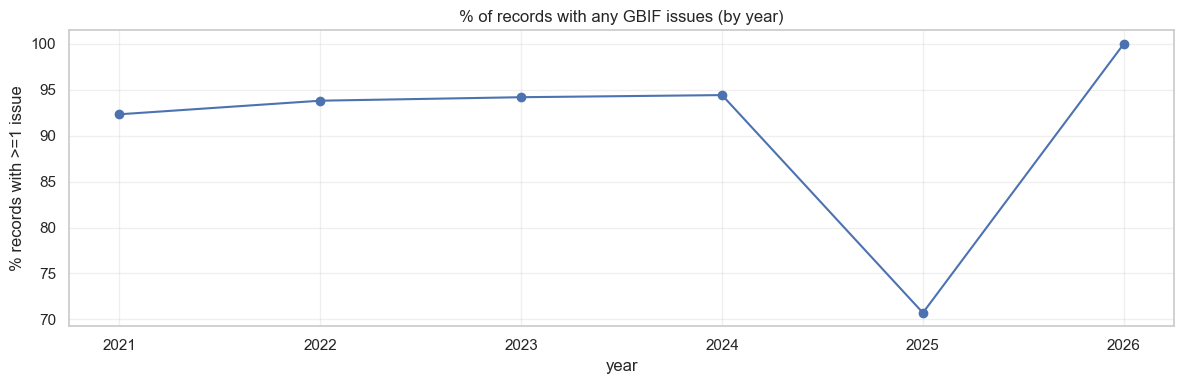

In [6]:
from collections import Counter, defaultdict

import pyarrow.parquet as pq


def parse_issues(value) -> list[str]:
    if value is None or (isinstance(value, float) and pd.isna(value)):
        return []
    s = str(value).strip()
    if not s:
        return []
    parts = [p.strip() for p in s.replace(";", ",").split(",")]
    return [p for p in parts if p]


# Stream issues EDA from parquet files (avoids schema-unification crashes)
per_year_total = Counter()
per_year_any_issue = Counter()
per_year_issue_counts: dict[int, Counter] = defaultdict(Counter)
issue_counts_overall = Counter()

for row in files_index.itertuples(index=False):
    year = int(row.year)
    pf = pq.ParquetFile(row.path)
    n = int(row.num_rows)
    per_year_total[year] += n

    if "issue" not in pf.schema_arrow.names:
        continue

    t = pf.read(columns=["issue"])
    issues_col = t.column(0)  # ChunkedArray

    for v in issues_col.to_pylist():
        codes = parse_issues(v)
        if codes:
            per_year_any_issue[year] += 1
            for c in codes:
                per_year_issue_counts[year][c] += 1
                issue_counts_overall[c] += 1

by_year_issues = (
    pd.DataFrame({"year": sorted(per_year_total.keys())})
    .assign(
        records=lambda d: d["year"].map(per_year_total).astype(int),
        records_with_any_issue=lambda d: d["year"].map(per_year_any_issue).fillna(0).astype(int),
    )
)
by_year_issues["pct_with_any_issue"] = (
    by_year_issues["records_with_any_issue"] / by_year_issues["records"] * 100
).round(2)

top_issues_overall = pd.DataFrame(issue_counts_overall.most_common(), columns=["issue", "records"])
if len(top_issues_overall):
    top_issues_overall["pct_of_all_records"] = (
        top_issues_overall["records"] / sum(per_year_total.values()) * 100
    ).round(3)

display(by_year_issues)
display(top_issues_overall.head(30))

# Top issues per year (optional)
TOP_K = 10
rows = []
for y in sorted(per_year_issue_counts.keys()):
    total_y = int(per_year_total[y])
    for issue, cnt in per_year_issue_counts[y].most_common(TOP_K):
        rows.append(
            {
                "year": y,
                "issue": issue,
                "records": int(cnt),
                "pct_of_year_records": round(cnt / total_y * 100, 4) if total_y else 0.0,
            }
        )

top_issues_by_year = pd.DataFrame(rows)
display(top_issues_by_year)

plt.figure(figsize=(12, 4))
plt.plot(by_year_issues["year"], by_year_issues["pct_with_any_issue"], marker="o")
plt.title("% of records with any GBIF issues (by year)")
plt.xlabel("year")
plt.ylabel("% records with >=1 issue")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Total columns in union schema: 50
Columns checked: 50
Example columns: ['basisOfRecord', 'catalogNumber', 'class', 'collectionCode', 'coordinatePrecision', 'coordinateUncertaintyInMeters', 'countryCode', 'datasetKey', 'dateIdentified', 'day', 'decimalLatitude', 'decimalLongitude', 'depth', 'depthAccuracy', 'download_key', 'elevation', 'elevationAccuracy', 'establishmentMeans', 'eventDate', 'family', 'gbifID', 'genus', 'identifiedBy', 'individualCount', 'infraspecificEpithet']


,year,records,basisOfRecord,catalogNumber,class,collectionCode,coordinatePrecision,coordinateUncertaintyInMeters,countryCode,datasetKey,...,rightsHolder,scientificName,species,speciesKey,stateProvince,taxonKey,taxonRank,typeStatus,verbatimScientificName,verbatimScientificNameAuthorship
0,2021,6335175,100.0,79.7011,99.0211,85.6613,0.0090,15.9280,100.0,100.0,...,12.5937,100.0,96.7096,96.7096,87.4459,100.0,100.0,0.0028,99.9919,10.0330
1,2022,6790136,100.0,84.4064,99.0623,90.3214,0.0010,15.0101,100.0,100.0,...,14.5402,100.0,97.8614,97.8614,92.7337,100.0,100.0,0.0014,98.8261,7.4486
2,2023,7022640,100.0,89.3270,99.3062,92.6706,0.0010,13.7161,100.0,100.0,...,16.0493,100.0,99.0086,99.0086,96.0272,100.0,100.0,0.0005,99.9995,2.8609
3,2024,7413297,100.0,90.8066,99.3921,92.5307,0.0018,12.9967,100.0,100.0,...,15.1812,100.0,99.1394,99.1394,96.8621,100.0,100.0,0.0003,99.9998,1.2971
4,2025,1038958,100.0,62.5318,98.1783,64.4850,0.0014,78.9911,100.0,100.0,...,94.7306,100.0,98.5937,98.5937,94.0643,100.0,100.0,0.0000,99.9992,3.2178


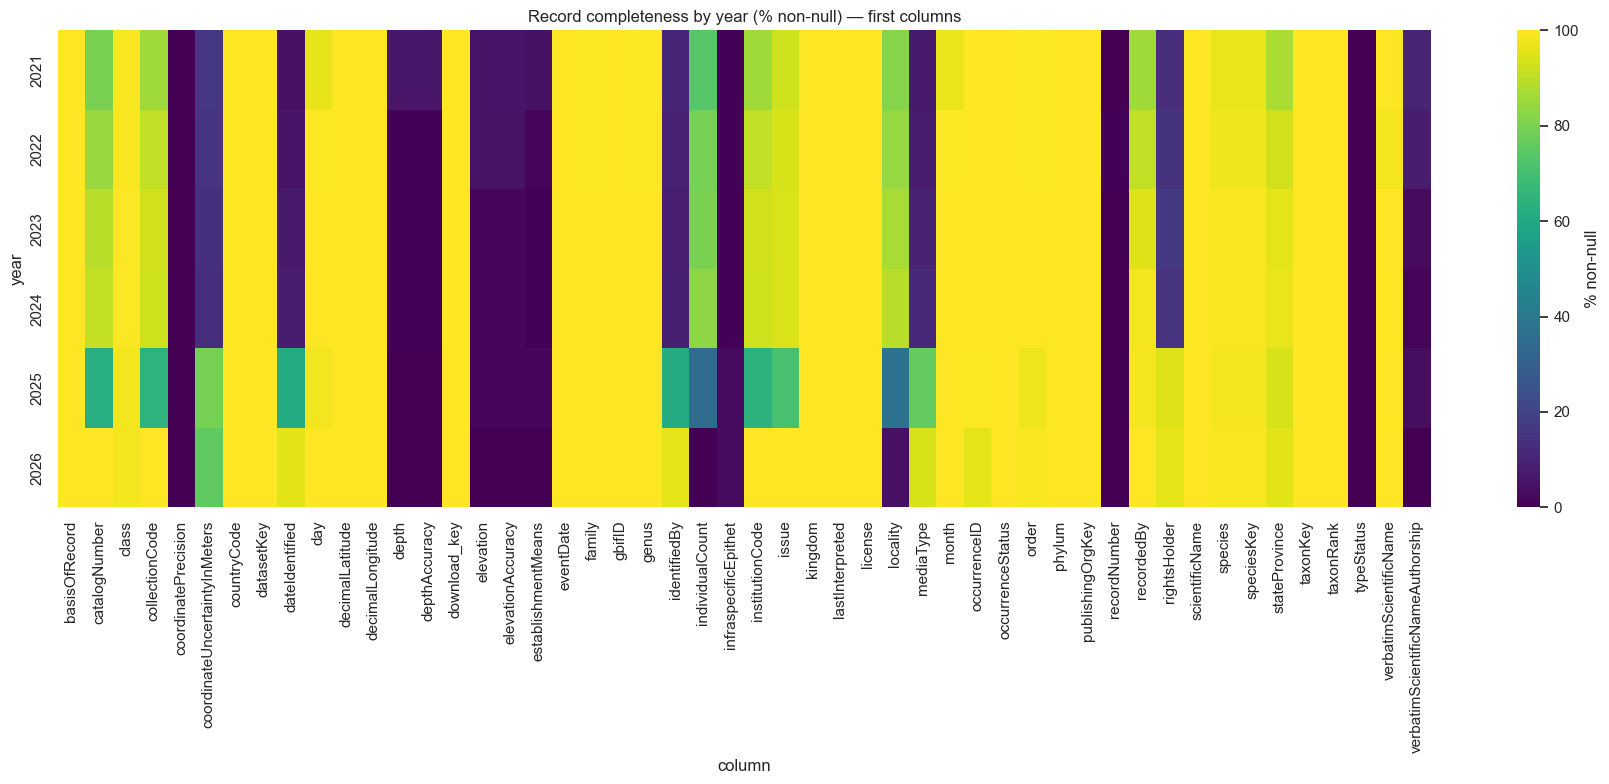

Note: `comp` contains completeness for all selected columns; heatmap shows a subset for readability.


In [16]:
import pyarrow.parquet as pq


def get_union_columns(files: list[Path]) -> list[str]:
    cols = set()
    for f in files:
        pf = pq.ParquetFile(f)
        cols.update(pf.schema_arrow.names)
    # keep a stable order (alphabetical)
    return sorted(cols)


# By default compute completeness for ALL columns in the exports.
# If you want a smaller subset, set COLUMNS_TO_CHECK = ["eventDate", ...]
COLUMNS_TO_CHECK: list[str] | None = None

ALL_COLS = get_union_columns(parquet_files)
cols = ALL_COLS if COLUMNS_TO_CHECK is None else [c for c in COLUMNS_TO_CHECK if c in ALL_COLS]

print("Total columns in union schema:", len(ALL_COLS))
print("Columns checked:", len(cols))
print("Example columns:", cols[:25])

# Accumulate non-null counts per (year, column) by streaming per file
from collections import Counter, defaultdict

per_year_total_rows = Counter()
per_year_non_null: dict[int, Counter] = defaultdict(Counter)

COLUMN_BATCH = 25

for row in files_index.itertuples(index=False):
    year = int(row.year)
    pf = pq.ParquetFile(row.path)
    n = int(row.num_rows)
    per_year_total_rows[year] += n

    file_cols = set(pf.schema_arrow.names)

    for i in range(0, len(cols), COLUMN_BATCH):
        batch = [c for c in cols[i : i + COLUMN_BATCH] if c in file_cols]
        if not batch:
            continue

        t = pf.read(columns=batch)
        for c in batch:
            # ChunkedArray null_count is fast and doesn't require converting to pandas
            nn = n - t.column(c).null_count
            per_year_non_null[year][c] += int(nn)

# Build % completeness table: one row per year, one column per field (% non-null)
years_sorted = sorted(per_year_total_rows.keys())
out_rows = []
for y in years_sorted:
    total = int(per_year_total_rows[y])
    row = {"year": y, "records": total}
    for c in cols:
        nn = int(per_year_non_null[y].get(c, 0))
        row[c] = round(nn / total * 100, 4) if total else 0.0
    out_rows.append(row)

comp = pd.DataFrame(out_rows)
display(comp.head())

# Heatmap (if not too wide)
MAX_COLS_FOR_HEATMAP = 51
heat_cols = cols[:MAX_COLS_FOR_HEATMAP]

if len(comp) and len(heat_cols):
    mat = comp.set_index("year")[heat_cols]
    plt.figure(figsize=(min(18, 0.45 * len(heat_cols) + 6), 8))
    if sns is not None:
        sns.heatmap(mat, cmap="viridis", cbar_kws={"label": "% non-null"})
    else:
        plt.imshow(mat.values, aspect="auto")
        plt.yticks(range(len(mat.index)), mat.index)
        plt.xticks(range(len(mat.columns)), mat.columns, rotation=90)
    plt.title("Record completeness by year (% non-null) — first columns")
    plt.xlabel("column")
    plt.ylabel("year")
    plt.tight_layout()
    plt.show()

print("Note: `comp` contains completeness for all selected columns; heatmap shows a subset for readability.")


,year,records
0,2021,6335175
1,2022,6790136
2,2023,7022640
3,2024,7413297
4,2025,1038958
5,2026,24341


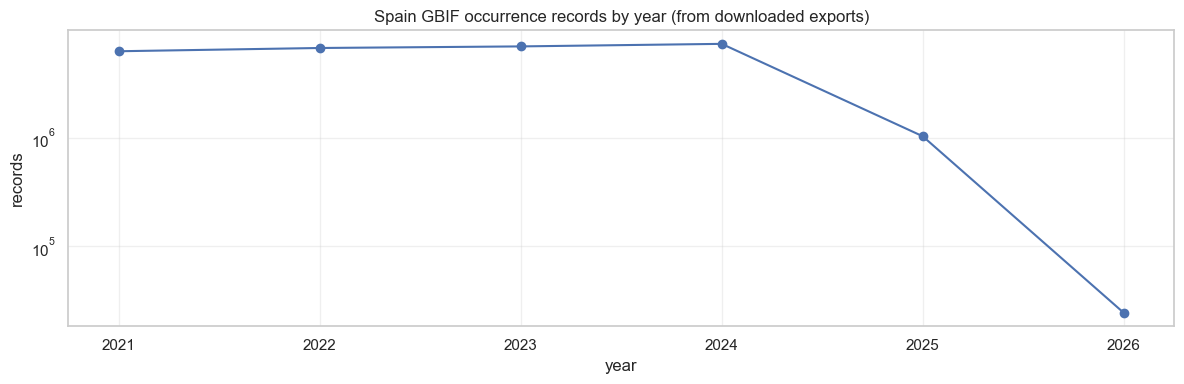

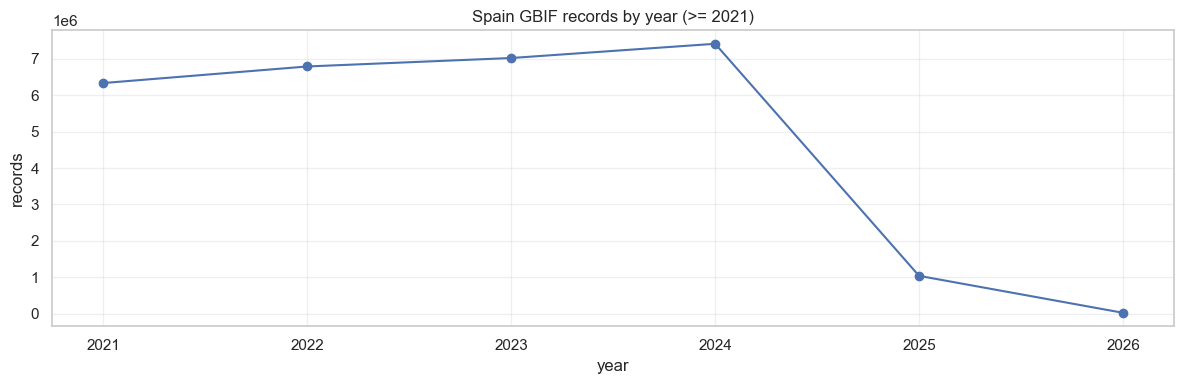

In [17]:
# Occurrence counts over time (year-by-year)
# Use parquet metadata counts (fast; no full data read)

by_year = by_year_meta.copy()

by_year = by_year.sort_values("year")
display(by_year.tail(10))

plt.figure(figsize=(12, 4))
plt.plot(by_year["year"], by_year["records"], marker="o")
plt.title("Spain GBIF occurrence records by year (from downloaded exports)")
plt.xlabel("year")
plt.ylabel("records")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Linear-scale view (recent window)
RECENT_FROM = max(2010, int(by_year["year"].min()))
recent = by_year[by_year["year"] >= RECENT_FROM]
plt.figure(figsize=(12, 4))
plt.plot(recent["year"], recent["records"], marker="o")
plt.title(f"Spain GBIF records by year (>= {RECENT_FROM})")
plt.xlabel("year")
plt.ylabel("records")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Optional: load selected years into memory (pandas DataFrame)

The notebook above avoids loading everything into one DataFrame because:
- Spain exports can be **very large** (RAM pressure)
- your Parquet files can have **schema/type differences** (e.g. a column being `null` in one file and `string` in another), which can crash a single multi-file read

If you still want an in-memory DataFrame (e.g. for ad-hoc exploration), use the cell below.

**Tip:** start with a small year range (e.g. 2024–2026) and/or a small column subset.

In [20]:
import pyarrow.parquet as pq

# --- Toggle
LOAD_IN_MEMORY = True

# Choose which years to load
YEARS_TO_LOAD = list(range(2020, 2026 + 1))

# Choose columns to load (None = load all columns, can be heavy)
# For most EDA, a subset is enough.
COLUMNS_TO_LOAD = [
    c
    for c in [
        "year",
        "eventDate",
        "countryCode",
        "stateProvince",
        "county",
        "basisOfRecord",
        "species",
        "scientificName",
        "speciesKey",
        "decimalLatitude",
        "decimalLongitude",
        "coordinateUncertaintyInMeters",
        "datasetKey",
        "publishingOrgKey",
        "license",
        "issues",
        "issue",
        "download_key",
        "iucnRedListCategory",
        "establishmentMeans",
        "degreeOfEstablishment",
    ]
]

# If True, coerce known mixed-type columns to string to avoid concat/type conflicts
COERCE_MIXED_TO_STRING = True
MIXED_TYPE_COLS = [
    "infraspecificEpithet",
    "verbatimScientificNameAuthorship",
    "recordNumber",
    "identifiedBy",
    "dateIdentified",
    "rightsHolder",
    "typeStatus",
    "establishmentMeans",
    "mediaType",
]


def read_parquet_file_to_df(path: str, year: int) -> pd.DataFrame:
    pf = pq.ParquetFile(path)

    cols = pf.schema_arrow.names

    # Decide column set
    if COLUMNS_TO_LOAD is None:
        use_cols = cols
    else:
        # include only columns that exist in this file
        use_cols = [c for c in COLUMNS_TO_LOAD if c in cols]

    t = pf.read(columns=use_cols)
    out = t.to_pandas()

    # Ensure year exists
    if "year" not in out.columns:
        out["year"] = year

    # Optional coercions for stability
    if COERCE_MIXED_TO_STRING:
        for c in MIXED_TYPE_COLS:
            if c in out.columns:
                out[c] = out[c].astype("string")

    return out


df_all = None
if LOAD_IN_MEMORY:
    parts = []

    subset = files_index[files_index["year"].isin(YEARS_TO_LOAD)].copy()
    print("Files selected:", len(subset))

    for r in subset.itertuples(index=False):
        y = int(r.year)
        dfi = read_parquet_file_to_df(r.path, y)
        parts.append(dfi)

    print("Concatenating parts...")
    df_all = pd.concat(parts, ignore_index=True)

    # Basic sanity
    df_all["year"] = pd.to_numeric(df_all["year"], errors="coerce").astype("Int64")
    print("Loaded rows:", len(df_all))
    print("Loaded columns:", len(df_all.columns))
    print("Years:", sorted(pd.Series(df_all["year"].dropna().unique()).astype(int).tolist()))
    display(df_all.head(5))
else:
    print("LOAD_IN_MEMORY is False -> skipping full in-memory load.")
    print("Set LOAD_IN_MEMORY=True to run.")

Files selected: 33
Concatenating parts...
Loaded rows: 28624547
Loaded columns: 17
Years: [2021, 2022, 2023, 2024, 2025, 2026]


,eventDate,countryCode,stateProvince,basisOfRecord,species,scientificName,speciesKey,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,datasetKey,publishingOrgKey,license,issue,download_key,establishmentMeans,year
0,2021-02-23,ES,Madrid Comunidad de,HUMAN_OBSERVATION,Saxicola rubicola,"Saxicola rubicola (Linnaeus, 1766)",4408759,40.77821,-3.66561,<NA>,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,e2e717bf-551a-4917-bdc9-4fa0f342c530,CC_BY_4_0,CONTINENT_DERIVED_FROM_COORDINATES;TAXON_CONCE...,0003567-260208012135463,<NA>,2021
1,2021-04-14,ES,Extremadura,HUMAN_OBSERVATION,Galerida theklae,"Galerida theklae A.E.Brehm, 1857",9330514,38.81858,-5.237153,<NA>,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,e2e717bf-551a-4917-bdc9-4fa0f342c530,CC_BY_4_0,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,0003567-260208012135463,<NA>,2021
2,2021-08-25,ES,Extremadura,HUMAN_OBSERVATION,Ardea alba,"Ardea alba Linnaeus, 1758",9752617,39.81576,-5.729745,<NA>,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,e2e717bf-551a-4917-bdc9-4fa0f342c530,CC_BY_4_0,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,0003567-260208012135463,<NA>,2021
3,2021-06-03,ES,Galicia,HUMAN_OBSERVATION,Phylloscopus ibericus,"Phylloscopus ibericus Ticehurst, 1937",7341585,42.61257,-8.361325,<NA>,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,e2e717bf-551a-4917-bdc9-4fa0f342c530,CC_BY_4_0,CONTINENT_DERIVED_FROM_COORDINATES;TAXON_CONCE...,0003567-260208012135463,<NA>,2021
4,2021-06-06,ES,Andalucía,HUMAN_OBSERVATION,Tachybaptus ruficollis,"Tachybaptus ruficollis (Pallas, 1764)",2482048,37.221924,-1.811864,<NA>,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,e2e717bf-551a-4917-bdc9-4fa0f342c530,CC_BY_4_0,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,0003567-260208012135463,<NA>,2021


In [17]:
df_all['establishmentMeans'].value_counts()

establishmentMeans
native        481510
introduced      7594
Name: count, dtype: int64[pyarrow]

## EDA on `df_all` (in-memory) — licenses by year + city-regions over time

This section assumes you ran the optional in-memory load cell and have a DataFrame named `df_all`.

If `df_all` is `None`, set `LOAD_IN_MEMORY=True` in the previous cell and re-run it.

In [12]:
if df_all is None:
    raise RuntimeError("df_all is None. Run the optional in-memory load cell with LOAD_IN_MEMORY=True.")

# Make sure year is present and filtered to the intended window
YEAR_MIN = 2020
YEAR_MAX = 2026

if "year" not in df_all.columns:
    raise ValueError("df_all must contain a 'year' column")

df_all["year"] = pd.to_numeric(df_all["year"], errors="coerce").astype("Int64")
df_all = df_all[df_all["year"].between(YEAR_MIN, YEAR_MAX)].copy()

print("df_all rows (after year filter):", len(df_all))
print("years:", sorted(pd.Series(df_all["year"].dropna().unique()).astype(int).tolist()))
print("columns:", len(df_all.columns))

df_all rows (after year filter): 28624547
years: [2021, 2022, 2023, 2024, 2025, 2026]
columns: 16


In [24]:
df_all['license'].value_counts()

license
CC_BY_4_0       23073416
CC_BY_NC_4_0     4703471
CC0_1_0           847660
Name: count, dtype: int64[pyarrow]

,year,license_label,records,total,pct
0,2021,CC_BY_4_0,5079117,6335175,80.173
1,2021,CC_BY_NC_4_0,1004847,6335175,15.861
2,2021,CC0_1_0,251211,6335175,3.965
3,2022,CC_BY_4_0,5708782,6790136,84.075
4,2022,CC_BY_NC_4_0,822838,6790136,12.118
5,2022,CC0_1_0,258516,6790136,3.807
6,2023,CC_BY_4_0,5844345,7022640,83.221
7,2023,CC_BY_NC_4_0,934464,7022640,13.306
8,2023,CC0_1_0,243831,7022640,3.472
9,2024,CC_BY_4_0,6313394,7413297,85.163


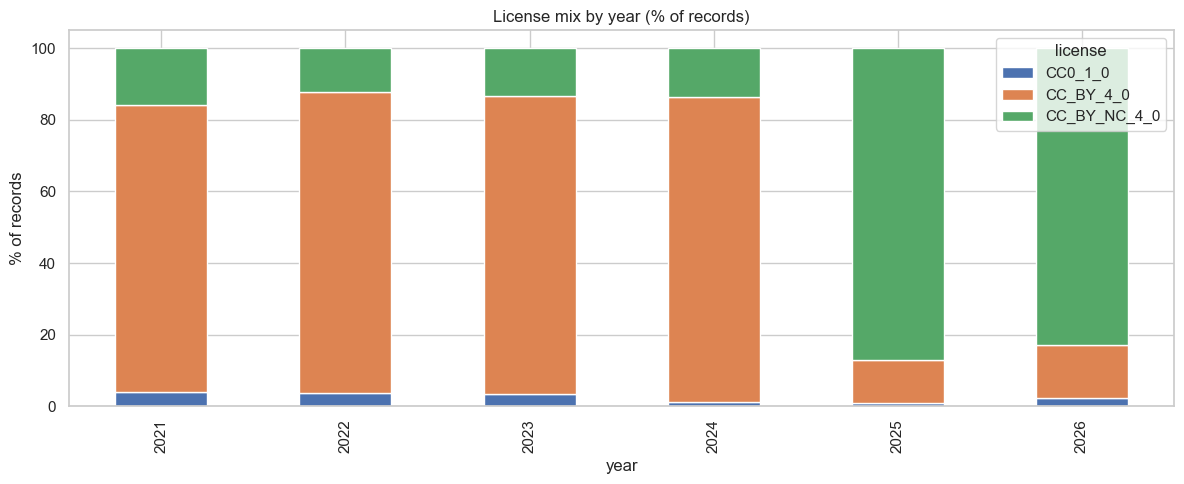

Top licenses per year (by records):


,year,license_label,records,total,pct
0,2021,CC_BY_4_0,5079117,6335175,80.173
1,2021,CC_BY_NC_4_0,1004847,6335175,15.861
2,2021,CC0_1_0,251211,6335175,3.965
3,2022,CC_BY_4_0,5708782,6790136,84.075
4,2022,CC_BY_NC_4_0,822838,6790136,12.118
5,2022,CC0_1_0,258516,6790136,3.807
6,2023,CC_BY_4_0,5844345,7022640,83.221
7,2023,CC_BY_NC_4_0,934464,7022640,13.306
8,2023,CC0_1_0,243831,7022640,3.472
9,2024,CC_BY_4_0,6313394,7413297,85.163


In [13]:
# 1) Licenses per year

df_all["license_label"] = df_all["license"]

lic_by_year = (
    df_all.groupby(["year", "license_label"]).size().rename("records").reset_index().sort_values(["year", "records"], ascending=[True, False])
)

total_by_year = df_all.groupby("year").size().rename("total").reset_index()
lic_by_year = lic_by_year.merge(total_by_year, on="year", how="left")
lic_by_year["pct"] = (lic_by_year["records"] / lic_by_year["total"] * 100).round(3)

display(lic_by_year)

# Plot: stacked % by year
pivot_pct = lic_by_year.pivot_table(index="year", columns="license_label", values="pct", aggfunc="sum").fillna(0)

plt.figure(figsize=(12, 5))
# stable column order
order = [c for c in ["CC0 1.0", "CC BY 4.0", "CC BY-NC 4.0", "OTHER", "MISSING"] if c in pivot_pct.columns]
if order:
    pivot_pct = pivot_pct[order]

pivot_pct.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("License mix by year (% of records)")
plt.xlabel("year")
plt.ylabel("% of records")
plt.legend(title="license")
plt.tight_layout()
plt.show()

print("Top licenses per year (by records):")
display(lic_by_year.sort_values(["year", "records"], ascending=[True, False]).groupby("year").head(3))

Region assignment counts:


region_city
Other Spain    21211293
Madrid          2515732
Barcelona       1502881
Bilbao           940626
Málaga           843163
Valencia         828694
Sevilla          782158
Name: count, dtype: int64

,year,region_city,records
4,2021,Other Spain,4739069
2,2021,Madrid,612835
0,2021,Barcelona,311480
1,2021,Bilbao,200944
6,2021,Valencia,178823
5,2021,Sevilla,153676
3,2021,Málaga,138348
11,2022,Other Spain,5011312
9,2022,Madrid,581740
7,2022,Barcelona,355641


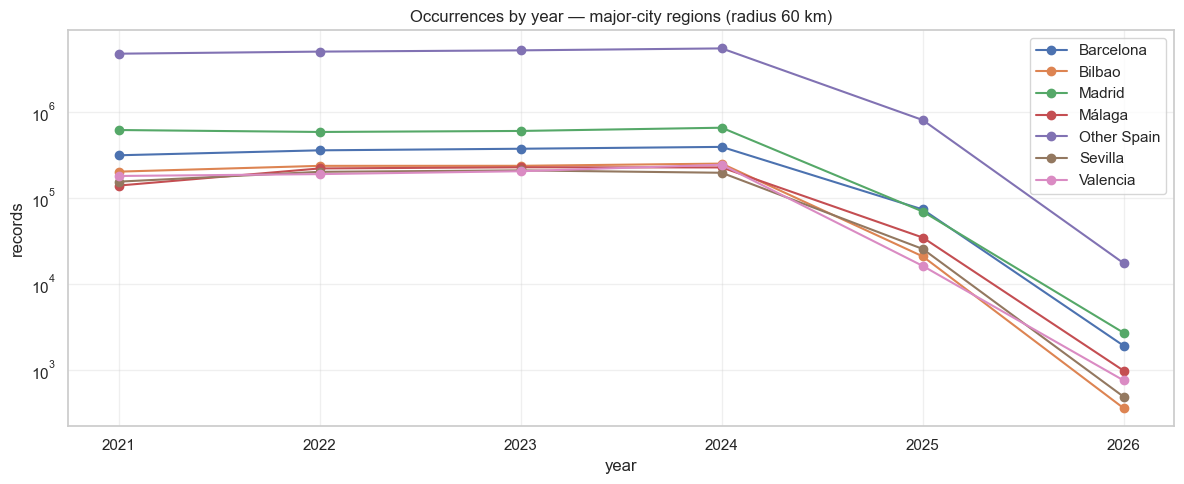

In [26]:
# 2) "Regions" proxy: major cities + radius (km)
# We assign each occurrence to the nearest city if it's within CITY_RADIUS_KM.

if not {"decimalLatitude", "decimalLongitude"}.issubset(df_all.columns):
    raise ValueError("df_all must contain decimalLatitude/decimalLongitude for city-region assignment")

# City centers (lat, lon)
CITIES = {
    "Madrid": (40.4168, -3.7038),
    "Barcelona": (41.3851, 2.1734),
    "Valencia": (39.4699, -0.3763),
    "Sevilla": (37.3891, -5.9845),
    "Málaga": (36.7213, -4.4214),
    "Bilbao": (43.2630, -2.9350),
}

CITY_RADIUS_KM = 60.0

# Haversine distance (vectorized)
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    return 2 * R * np.arcsin(np.sqrt(a))

# Clean coords
coords = df_all[["decimalLatitude", "decimalLongitude"]].copy()
coords["decimalLatitude"] = pd.to_numeric(coords["decimalLatitude"], errors="coerce")
coords["decimalLongitude"] = pd.to_numeric(coords["decimalLongitude"], errors="coerce")
valid = coords["decimalLatitude"].notna() & coords["decimalLongitude"].notna()

# Compute nearest city
lat = coords.loc[valid, "decimalLatitude"].to_numpy()
lon = coords.loc[valid, "decimalLongitude"].to_numpy()

city_names = list(CITIES.keys())
city_lats = np.array([CITIES[n][0] for n in city_names])
city_lons = np.array([CITIES[n][1] for n in city_names])

# distances: (n_points, n_cities)
dists = np.vstack([haversine_km(lat, lon, city_lats[i], city_lons[i]) for i in range(len(city_names))]).T
nearest_idx = dists.argmin(axis=1)
nearest_dist = dists[np.arange(len(lat)), nearest_idx]
nearest_city = np.array(city_names, dtype=object)[nearest_idx]

region = np.full(len(df_all), "MISSING_COORD", dtype=object)
region[valid.to_numpy()] = np.where(nearest_dist <= CITY_RADIUS_KM, nearest_city, "Other Spain")

df_all["region_city"] = region

print("Region assignment counts:")
display(df_all["region_city"].value_counts().head(20))

# Yearly counts per region
reg_year = df_all.groupby(["year", "region_city"]).size().rename("records").reset_index()
reg_year = reg_year.sort_values(["year", "records"], ascending=[True, False])
display(reg_year.head(20))

# Plot time series for the main regions
TOP_REGIONS = [r for r in df_all["region_city"].value_counts().index.tolist() if r not in {"MISSING_COORD"}][:8]
reg_piv = reg_year[reg_year["region_city"].isin(TOP_REGIONS)].pivot_table(index="year", columns="region_city", values="records", aggfunc="sum").fillna(0)

plt.figure(figsize=(12, 5))
for c in reg_piv.columns:
    plt.plot(reg_piv.index, reg_piv[c], marker="o", label=c)
plt.title(f"Occurrences by year — major-city regions (radius {CITY_RADIUS_KM:.0f} km)")
plt.xlabel("year")
plt.ylabel("records")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Publishers (datasets) EDA

We analyze by **datasetKey** (each dataset = one publisher's content). If `publishingOrgKey` is available, we use it for organization-level aggregation.

- **Over time**: record counts per publisher per year
- **2024 share**: market share of top publishers
- **Validation/scoring**: proposed quality and reliability metrics

In [9]:
# Publisher = datasetKey (or publishingOrgKey if available)
publisher_col = "publishingOrgKey" if "publishingOrgKey" in df_all.columns else "datasetKey"
pub_label = "publisher (org)" if publisher_col == "publishingOrgKey" else "publisher (dataset)"

# Fill missing with placeholder
df_pub = df_all[[publisher_col, "year"]].copy()
df_pub[publisher_col] = df_pub[publisher_col].fillna("UNKNOWN").astype(str)

# 1) Publishers over time
pub_by_year = df_pub.groupby([publisher_col, "year"]).size().rename("records").reset_index()
pub_year_pivot = pub_by_year.pivot_table(index="year", columns=publisher_col, values="records", aggfunc="sum").fillna(0)

# Top N publishers by total records (for plot clarity)
top_pubs = df_pub.groupby(publisher_col).size().nlargest(15).index.tolist()
pub_top = pub_year_pivot[[c for c in top_pubs if c in pub_year_pivot.columns]]

fig, ax = plt.subplots(figsize=(12, 5))
pub_top.plot(kind="area", stacked=True, ax=ax, alpha=0.8)
ax.set_title(f"Records by {pub_label} over time (top 15)")
ax.set_xlabel("year")
ax.set_ylabel("records")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

# 2) 2024 share
df_2024 = df_pub[df_pub["year"] == 2024]
share_2024 = df_2024[publisher_col].value_counts(normalize=True).mul(100).round(2)
share_2024_counts = df_2024[publisher_col].value_counts()

print("2024 share (top 20):")
share_df = pd.DataFrame({"pct": share_2024, "records": share_2024_counts}).head(20)
display(share_df)

fig, ax = plt.subplots(figsize=(10, 5))
share_2024.head(15).plot(kind="barh", ax=ax)
ax.set_title("Publisher share of Spain records, 2024 (%)")
ax.set_xlabel("% of records")
plt.tight_layout()
plt.show()

# 3) Proposed publisher validation/scoring
# Score components (0–1 each): completeness, quality, consistency, growth
def publisher_score(df: pd.DataFrame, pub_col: str, year_col: str = "year") -> pd.DataFrame:
    """Compute a simple publisher quality score from available fields."""
    out = []
    for pub, g in df.groupby(pub_col):
        if pub == "UNKNOWN" or pd.isna(pub):
            continue
        n = len(g)
        # Completeness: % with coordinates (if available)
        coord_pct = 1.0
        if "decimalLatitude" in df.columns:
            has_coord = g["decimalLatitude"].notna() & g["decimalLongitude"].notna()
            coord_pct = has_coord.mean()
        # Quality: % without issues (if available)
        issue_pct = 1.0
        issue_col = "issues" if "issues" in df.columns else ("issue" if "issue" in df.columns else None)
        if issue_col:
            no_issues = g[issue_col].isna() | (g[issue_col].astype(str).str.strip() == "")
            issue_pct = no_issues.mean()
        # Consistency: license disclosure (if available)
        license_pct = 1.0
        if "license" in df.columns:
            has_license = g["license"].notna() & (g["license"].astype(str).str.strip() != "")
            license_pct = has_license.mean()
        # Growth: presence in recent years
        years = g[year_col].dropna().astype(int).unique()
        recent = [y for y in years if y >= 2023]
        growth_pct = len(recent) / 3.0 if years.size > 0 else 0  # cap at 1

        score = 0.3 * coord_pct + 0.3 * issue_pct + 0.2 * license_pct + 0.2 * min(growth_pct, 1)
        out.append({
            pub_col: pub,
            "records": n,
            "coord_pct": coord_pct,
            "issue_free_pct": issue_pct,
            "license_pct": license_pct,
            "score": round(score, 3),
        })
    return pd.DataFrame(out).sort_values("score", ascending=False)

df_score = df_all.copy()
df_score["year"] = pd.to_numeric(df_score["year"], errors="coerce")
score_col = "publishingOrgKey" if "publishingOrgKey" in df_score.columns else "datasetKey"
df_score[score_col] = df_score[score_col].fillna("UNKNOWN").astype(str)

publisher_scores = publisher_score(df_score, score_col)
print("Publisher validation scores (top 20):")
print("  Weights: coord 30%, issue-free 30%, license 20%, recency 20%")
display(publisher_scores.head(20))

NameError: name 'df_all' is not defined

## Invasive species EDA (Spain)

Uses `df_all` (Spain export) filtered by `establishmentMeans` in **INVASIVE**, **INTRODUCED**, **NATURALISED**. Groups by year, establishmentMeans, species.

Invasive/introduced records in df_all (Spain): 7594 / 28624547

Records by year:


,year,records
0,2021,2431
1,2022,2159
2,2023,1097
3,2024,1368
4,2025,539



Records by establishmentMeans:


,establishmentMeans,records
0,INTRODUCED,7594



Records by year × establishmentMeans:


,year,establishmentMeans,records
0,2021,INTRODUCED,2431
1,2022,INTRODUCED,2159
2,2023,INTRODUCED,1097
3,2024,INTRODUCED,1368
4,2025,INTRODUCED,539



Top 25 invasive/introduced species:


,establishmentMeans,species,records
38,INTRODUCED,Arundo donax,801
22,INTRODUCED,Ailanthus altissima,791
92,INTRODUCED,Cylindropuntia imbricata,415
267,INTRODUCED,Trachemys scripta,317
127,INTRODUCED,Gambusia holbrooki,313
12,INTRODUCED,Agave americana,269
211,INTRODUCED,Oxalis pes-caprae,265
153,INTRODUCED,Lantana camara,231
201,INTRODUCED,Opuntia ficus-indica,220
35,INTRODUCED,Araujia sericifera,184


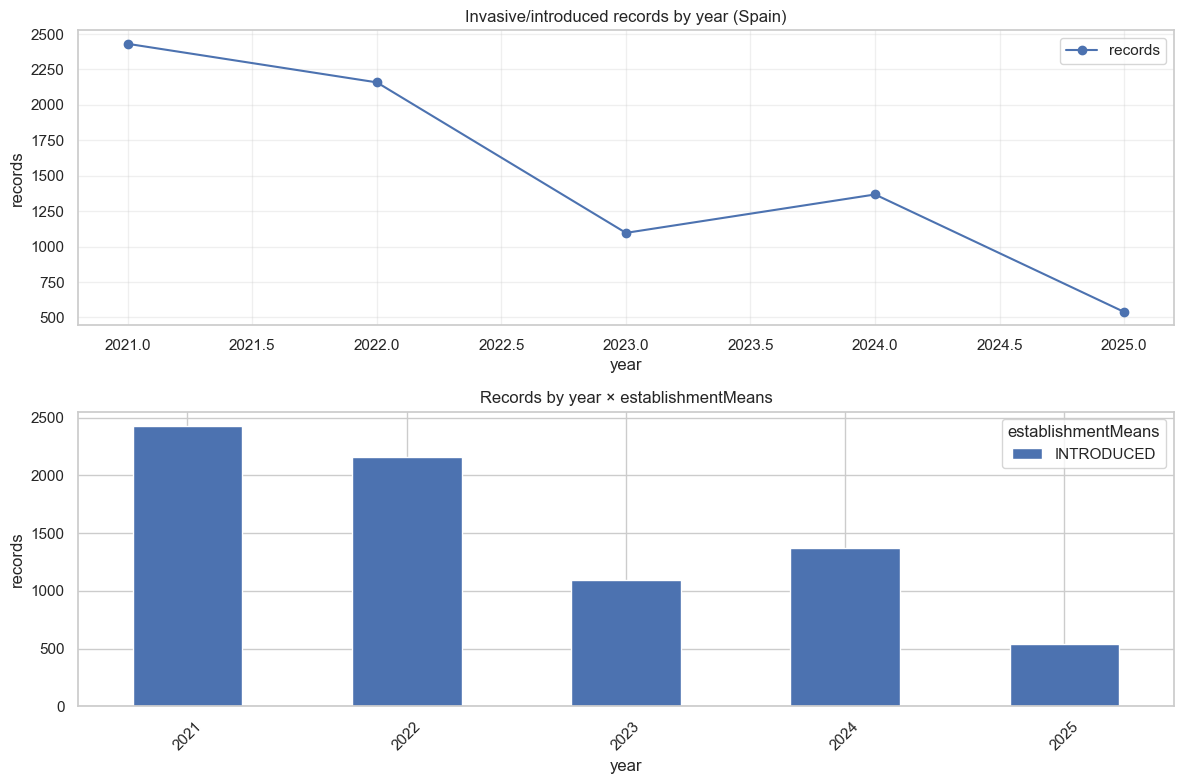

In [18]:
# Invasive species EDA: use df_all (Spain export), group by year / establishmentMeans / species
if df_all is None:
    raise RuntimeError("df_a`ll is None. Run the optional in-memory load cell with LOAD_IN_MEMORY=True.")

if "establishmentMeans" not in df_all.columns:
    raise ValueError("df_all must contain 'establishmentMeans'. Add it to COLUMNS_TO_LOAD.")

INVASIVE_MEANS = ["INVASIVE", "INTRODUCED", "NATURALISED"]
em_upper = df_all["establishmentMeans"].fillna("").astype(str).str.strip().str.upper()
mask = em_upper.isin(INVASIVE_MEANS)
df_inv = df_all[mask].copy()

SPECIES_COL = "species" if "species" in df_inv.columns else ("scientificName" if "scientificName" in df_inv.columns else None)
if SPECIES_COL:
    df_inv["species"] = df_inv[SPECIES_COL]
else:
    df_inv["species"] = "unknown"

df_inv["year"] = pd.to_numeric(df_inv["year"], errors="coerce")
df_inv["establishmentMeans"] = em_upper[mask]

print(f"Invasive/introduced records in df_all (Spain): {len(df_inv)} / {len(df_all)}")

if len(df_inv) == 0:
    print("No records found. Check establishmentMeans values or API.")
else:
    # Group by year (drop rows without year for time series)
    df_yr = df_inv.dropna(subset=["year"])
    by_year = df_yr.groupby("year").size().rename("records").reset_index().sort_values("year")
    print("\nRecords by year:")
    display(by_year)

    # Group by establishmentMeans
    by_em = df_inv.groupby("establishmentMeans").size().rename("records").reset_index()
    print("\nRecords by establishmentMeans:")
    display(by_em)

    # Group by year + establishmentMeans
    by_year_em = (
        df_yr.groupby(["year", "establishmentMeans"])
        .size()
        .rename("records")
        .reset_index()
        .sort_values(["year", "establishmentMeans"])
    )
    print("\nRecords by year × establishmentMeans:")
    display(by_year_em)

    # Top species (overall)
    top_species = (
        df_inv.groupby(["establishmentMeans", "species"])
        .size()
        .rename("records")
        .reset_index()
        .sort_values("records", ascending=False)
    )
    print("\nTop 25 invasive/introduced species:")
    display(top_species.head(25))

    # Plots
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    by_year.plot(x="year", y="records", marker="o", ax=axes[0])
    axes[0].set_title("Invasive/introduced records by year (Spain)")
    axes[0].set_xlabel("year")
    axes[0].set_ylabel("records")
    axes[0].grid(True, alpha=0.3)

    pivot = by_year_em.pivot_table(index="year", columns="establishmentMeans", values="records", fill_value=0)
    pivot.plot(kind="bar", stacked=True, ax=axes[1])
    axes[1].set_title("Records by year × establishmentMeans")
    axes[1].set_xlabel("year")
    axes[1].set_ylabel("records")
    axes[1].legend(title="establishmentMeans")
    axes[1].tick_params(axis="x", rotation=45)
    plt.tight_layout()
    plt.show()

In [27]:
# Folium map: wszystkie wystąpienia invasive species za 2024 (Spain)
# Wymaga df_inv z komórki powyżej oraz decimalLatitude/decimalLongitude w df_all

if "df_inv" not in globals() or df_inv is None or len(df_inv) == 0:
    raise RuntimeError("df_inv jest puste. Uruchom komórkę Invasive species EDA powyżej.")

need_cols = ["decimalLatitude", "decimalLongitude", "establishmentMeans", "species"]
missing = [c for c in need_cols if c not in df_inv.columns]
if missing:
    raise ValueError(f"df_inv brakuje kolumn: {missing}. Dodaj decimalLatitude, decimalLongitude do COLUMNS_TO_LOAD.")

# Tylko rok 2024
# pts = df_inv[df_inv["year"] == 2024][need_cols].copy()
pts = df_inv[need_cols].copy()
pts["decimalLatitude"] = pd.to_numeric(pts["decimalLatitude"], errors="coerce")
pts["decimalLongitude"] = pd.to_numeric(pts["decimalLongitude"], errors="coerce")
pts = pts.dropna(subset=["decimalLatitude", "decimalLongitude"])

print(f"Rekordy invasive species 2024 z koordynatami: {len(pts)}")

if len(pts) == 0:
    print("Brak rekordów z 2024. Sprawdź dane lub rok.")
else:
    import folium

    # Ograniczenie do 15k punktów dla wydajności (Folium wolno przy dziesiątkach tysięcy)
    CAP = 15_000
    if len(pts) > CAP:
        pts_plot = pts.sample(n=CAP, random_state=42)
        print(f"Mapa pokazuje próbkę {CAP} z {len(pts)} rekordów.")
    else:
        pts_plot = pts

    m = folium.Map(location=[40.2, -3.5], zoom_start=6, tiles="cartodbpositron")
    color_by_em = {"INVASIVE": "#d62728", "INTRODUCED": "#ff7f0e", "NATURALISED": "#2ca02c"}

    for em, g in pts_plot.groupby("establishmentMeans"):
        fg = folium.FeatureGroup(name=f"{em} ({len(g)})")
        color = color_by_em.get(em, "blue")
        for row in g.itertuples(index=False):
            sp = str(getattr(row, "species", ""))[:50]
            folium.CircleMarker(
                location=[row.decimalLatitude, row.decimalLongitude],
                radius=3,
                color=color,
                fill=True,
                fill_opacity=0.6,
                weight=0,
                tooltip=f"{em} | {sp}",
            ).add_to(fg)
        fg.add_to(m)

    folium.LayerControl(collapsed=False).add_to(m)
    out_path = Path("pictures") / "spain_invasive_all_years_map.html"
    out_path.parent.mkdir(exist_ok=True)
    m.save(out_path)
    print("Zapisano mapę:", out_path)
    m

Rekordy invasive species 2024 z koordynatami: 7594
Zapisano mapę: pictures/spain_invasive_all_years_map.html


In [15]:
# Resolve publisher names from GBIF Registry API (publishingOrgKey -> organization title)
# Usage: fetch_org_names(["uuid1", "uuid2", ...]) returns {uuid: "Org Name", ...}
from pygbif import registry
import time

def fetch_org_names(keys: list[str], delay_s: float = 0.2) -> dict[str, str]:
    """Fetch organization titles from GBIF Registry for a list of publishingOrgKey (UUIDs)."""
    result = {}
    for k in keys:
        if k in ("UNKNOWN", "nan", "") or pd.isna(k):
            result[k] = str(k)
            continue
        k = str(k).strip()
        try:
            org = registry.organizations(uuid=k)
            # pygbif returns {"meta": ..., "data": {"title": "...", ...}}
            data = org.get("data", {}) if isinstance(org, dict) else {}
            title = data.get("title") if isinstance(data, dict) else None
            result[k] = title if title else k
        except Exception:
            result[k] = k
        time.sleep(delay_s)
    return result

# Get top publisher keys (from 2024 share or scores)
if publisher_col == "publishingOrgKey" and len(share_2024) > 0:
    top_keys = share_2024.head(20).index.astype(str).tolist()
    org_names = fetch_org_names(top_keys)
    print("Organization names (top 20 by 2024 share):")
    for k in top_keys:
        print(f"  {k[:8]}... -> {org_names.get(k, k)}")
    share_df = share_df.copy()
    share_df["org_name"] = share_df.index.astype(str).map(org_names)
    display(share_df[["org_name", "pct", "records"]].head(20))
else:
    print("Using datasetKey — org names apply to publishingOrgKey. Add publishingOrgKey to COLUMNS_TO_LOAD for name resolution.")

Organization names (top 20 by 2024 share):
  e2e717bf... -> Cornell Lab of Ornithology
  28eb1a3f... -> iNaturalist.org
  c8d737e0... -> Observation.org
  1cd669d0... -> Research Institute for Nature and Forest (INBO)
  da86174a... -> Pl@ntNet
  0e1238eb... -> ICES
  ebda1cab... -> Biodiversity data bank of Generalitat Valenciana
  ad2c7028... -> Institut de Ciències del Mar (CSIC)
  76c3443b... -> ENGIE
  e37fc40e... -> Universitat de les Illes Balears
  0c6d40e3... -> Birda
  bb646dff... -> naturgucker.de
  60674aba... -> Department of Animal Biology, Faculty of Biology, University of La Laguna
  1f00d75c... -> Xeno-canto Foundation for Nature Sounds
  52bd9c22... -> Navantia, S.A.
  8209258a... -> Botanical Garden, University of Valencia
  f5fc4e61... -> Lomonosov Moscow State University
  dfa60bf9... -> Instituto Pirenaico de Ecología (CSIC)
  0c392aa0... -> Biological Records Centre
  bf8bcf77... -> Dep. of Plant Biology, Ecology and Earth Sciences, Botany Area, Univ. Extremadura


,org_name,pct,records
publishingOrgKey,,,
e2e717bf-551a-4917-bdc9-4fa0f342c530,Cornell Lab of Ornithology,82.22,6095285
28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist.org,7.71,571260
c8d737e0-2ff8-42e8-b8fc-6b805d26fc5f,Observation.org,6.23,462101
1cd669d0-80ea-11de-a9d0-f1765f95f18b,Research Institute for Nature and Forest (INBO),0.88,65596
da86174a-a605-43a4-a5e8-53d484152cd3,Pl@ntNet,0.74,55024
0e1238eb-2c53-4ebe-a33f-0679b2e8c385,ICES,0.53,39505
ebda1cab-dda8-418b-8f25-df1e71ff5bc2,Biodiversity data bank of Generalitat Valenciana,0.31,23181
ad2c7028-26fd-49c6-88d2-457c207c387b,Institut de Ciències del Mar (CSIC),0.24,18071
76c3443b-bf10-4fb6-a6e7-aeaa65be383c,ENGIE,0.24,17564


### Introduced vs Invasive – co to jest i dlaczego to istotne?

- **Introduced (wprowadzony)**: gatunek przywieziony przez człowieka (celowo lub przypadkowo) poza swój naturalny zasięg. Nie musi jeszcze powodować szkód.
- **Invasive (inwazyjny)**: gatunek wprowadzony, który się rozprzestrzenia i powoduje szkody ekologiczne lub ekonomiczne.
- **Dlaczego to istotne**: śledzenie gatunków wprowadzonych pozwala na wczesne wykrywanie potencjalnych inwazji, biosecurity i ochronę rodzimej bioróżnorodności. W GBIF dane o „invasive” są w polu `degreeOfEstablishment`, a o „introduced” w `establishmentMeans`.

Kraje z największą liczbą rekordów gatunków INWAZYJNYCH (degreeOfEstablishment=invasive):
Łącznie rekordów: 162967


,country,count
0,IL,66804
1,ES,52230
2,NZ,22119
3,PS,6611
4,SY,4251
5,US,3629
6,CD,2696
7,CO,1490
8,CA,873
9,CL,620



Kraje z największą liczbą rekordów gatunków WPROWADZONYCH (establishmentMeans=introduced):
Łącznie rekordów: 6067942


,country,count
0,AU,3850587
1,US,792626
2,CL,414128
3,BE,304807
4,PT,235117
5,ES,66032
6,NZ,48242
7,BR,45824
8,RU,30765
9,ZA,26750


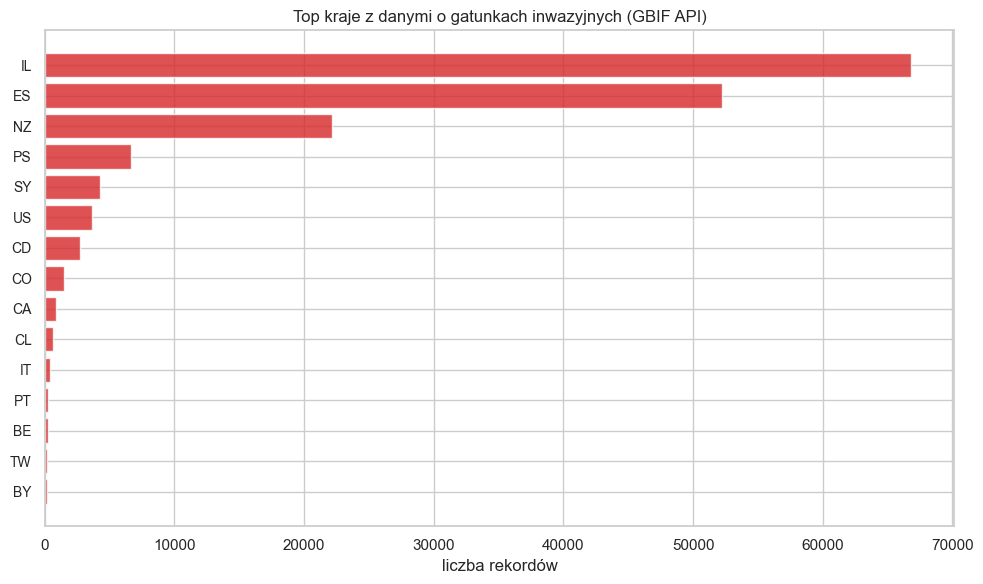

In [24]:
# Where are invasive species occurrences? (GBIF API – countries with invasive/introduced data)
# Queries GBIF API: degreeOfEstablishment=invasive (invasive) and establishmentMeans=introduced (introduced)

import requests

GBIF_OCC_URL = "https://api.gbif.org/v1/occurrence/search"

def fetch_country_facet(params: dict, facet_limit: int = 80) -> list[dict]:
    """Fetch occurrence counts by country via GBIF API facet."""
    p = {**params, "facet": "country", "limit": 0, "country.facetLimit": facet_limit}
    r = requests.get(GBIF_OCC_URL, params=p, timeout=30)
    r.raise_for_status()
    data = r.json()
    facets = data.get("facets", [])
    for f in facets:
        if f.get("field") == "COUNTRY":
            return f.get("counts", [])
    return []

# 1) Invasive species (degreeOfEstablishment=invasive) – gatunki inwazyjne
inv_params = {"degreeOfEstablishment": "invasive", "hasCoordinate": "true"}
inv_counts = fetch_country_facet(inv_params)
df_inv_api = pd.DataFrame(inv_counts).rename(columns={"name": "country"})
df_inv_api = df_inv_api.sort_values("count", ascending=False).reset_index(drop=True)

print("Kraje z największą liczbą rekordów gatunków INWAZYJNYCH (degreeOfEstablishment=invasive):")
print(f"Łącznie rekordów: {sum(df_inv_api['count'])}")
display(df_inv_api.head(25))

# 2) Introduced species (establishmentMeans=introduced) – gatunki wprowadzone
intro_params = {"establishmentMeans": "introduced", "hasCoordinate": "true"}
intro_counts = fetch_country_facet(intro_params)
df_intro_api = pd.DataFrame(intro_counts).rename(columns={"name": "country"})
df_intro_api = df_intro_api.sort_values("count", ascending=False).reset_index(drop=True)

print("\nKraje z największą liczbą rekordów gatunków WPROWADZONYCH (establishmentMeans=introduced):")
print(f"Łącznie rekordów: {sum(df_intro_api['count'])}")
display(df_intro_api.head(25))

# Wykres – top kraje (invasive)
top_n = 15
fig, ax = plt.subplots(figsize=(10, 6))
df_plot = df_inv_api.head(top_n)
ax.barh(range(len(df_plot)), df_plot["count"], color="#d62728", alpha=0.8)
ax.set_yticks(range(len(df_plot)))
ax.set_yticklabels(df_plot["country"], fontsize=10)
ax.invert_yaxis()
ax.set_xlabel("liczba rekordów")
ax.set_title("Top kraje z danymi o gatunkach inwazyjnych (GBIF API)")
plt.tight_layout()
plt.show()

In [23]:
# Map: sample occurrences by region_city (Folium)

import folium

# Filter map to a single year + proportional (stratified) sampling
MAP_YEAR = 2024
TOTAL_SAMPLE = 30_000

# Pick a species column (prefer `species`, fallback to `scientificName`)
SPECIES_COL = "species" if "species" in df_all.columns else ("scientificName" if "scientificName" in df_all.columns else None)
if SPECIES_COL is None:
    raise ValueError("df_all must contain either 'species' or 'scientificName' for tooltips")

need_cols = ["decimalLatitude", "decimalLongitude", "region_city", "year", SPECIES_COL]
for c in need_cols:
    if c not in df_all.columns:
        raise ValueError(f"Missing required column: {c}")

pts = df_all[need_cols].copy()
pts["year"] = pd.to_numeric(pts["year"], errors="coerce").astype("Int64")
pts = pts[pts["year"] == MAP_YEAR].copy()

pts["decimalLatitude"] = pd.to_numeric(pts["decimalLatitude"], errors="coerce")
pts["decimalLongitude"] = pd.to_numeric(pts["decimalLongitude"], errors="coerce")
pts = pts.dropna(subset=["decimalLatitude", "decimalLongitude"])

# Proportional allocation by region
region_counts = pts["region_city"].value_counts()
if len(region_counts) == 0:
    raise ValueError(f"No points available for year={MAP_YEAR} with valid coordinates")

total = int(region_counts.sum())
alloc = (region_counts / total * TOTAL_SAMPLE).round().astype(int)
alloc[alloc < 1] = 1
# cap by available
alloc = pd.concat([alloc, region_counts], axis=1)
alloc.columns = ["n_alloc", "n_available"]
alloc["n_alloc"] = alloc[["n_alloc", "n_available"]].min(axis=1).astype(int)

# adjust to match TOTAL_SAMPLE (best-effort)
diff = int(TOTAL_SAMPLE - alloc["n_alloc"].sum())
if diff != 0:
    # distribute +/-1 across regions with remaining capacity
    if diff > 0:
        candidates = alloc[alloc["n_alloc"] < alloc["n_available"]].copy()
        for r in candidates.index.tolist():
            if diff == 0:
                break
            alloc.loc[r, "n_alloc"] += 1
            diff -= 1
    else:
        # remove from regions with n_alloc>1
        candidates = alloc[alloc["n_alloc"] > 1].copy()
        for r in candidates.index.tolist():
            if diff == 0:
                break
            alloc.loc[r, "n_alloc"] -= 1
            diff += 1

print("Sampling plan (top 15):")
display(alloc.sort_values("n_alloc", ascending=False).head(15))
print("Total sample:", int(alloc["n_alloc"].sum()))

# Stratified sample (deterministic via random_state)
parts = []
for r, row in alloc.iterrows():
    n = int(row["n_alloc"])
    g = pts[pts["region_city"] == r]
    if n >= len(g):
        parts.append(g)
    else:
        parts.append(g.sample(n=n, random_state=42))

sampled = pd.concat(parts, ignore_index=True)

# Keep only required columns for mapping
sampled = sampled[["decimalLatitude", "decimalLongitude", "region_city", "year", SPECIES_COL]]

m = folium.Map(location=[40.2, -3.5], zoom_start=6, tiles="cartodbpositron")

# # city markers + radius circles
for name, (clat, clon) in CITIES.items():
    folium.Marker([clat, clon], tooltip=name).add_to(m)
    folium.Circle(
        location=[clat, clon],
        radius=int(CITY_RADIUS_KM * 1000),
        color="black",
        fill=False,
        weight=1,
        opacity=0.6,
        tooltip=f"{name} ~{CITY_RADIUS_KM:.0f}km",
    ).add_to(m)

# # color palette
palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]
region_list = sorted(sampled["region_city"].unique().tolist())
color_by_region = {r: palette[i % len(palette)] for i, r in enumerate(region_list)}

for r, g in sampled.groupby("region_city"):
    fg = folium.FeatureGroup(name=f"{r} ({len(g)})")
    color = color_by_region.get(r, "blue")
    for row in g.itertuples(index=False):
        sp = getattr(row, SPECIES_COL)
        sp = str(sp) if sp is not None else ""
        folium.CircleMarker(
            location=[row.decimalLatitude, row.decimalLongitude],
            radius=2,
            color=color,
            fill=True,
            fill_opacity=0.7,
            weight=0,
            tooltip=f"year={int(row.year) if pd.notna(row.year) else 'NA'} | {sp}",
        ).add_to(fg)
    fg.add_to(m)

folium.LayerControl(collapsed=True).add_to(m)

out_map = Path("pictures") / f"spain_city_regions_sample_map_year{MAP_YEAR}_n{TOTAL_SAMPLE}_r{int(CITY_RADIUS_KM)}km.html"
out_map.parent.mkdir(exist_ok=True)
m.save(out_map)

print("Saved map:", out_map)
out_map

ValueError: Missing required column: region_city

## Threatened species (IUCN) EDA + map (Spain, 2024)

We treat **"threatened"** as **VU / EN / CR**.

`iucnRedListCategory` is only in the search API, not in exports. The cell below fetches threatened species via `occurrences.search()` and joins to `df_all` to add `is_threatened` and `iucn_cat`.

In [9]:
# Threatened species via search API (iucnRedListCategory is only in search, not in export)
# Fetch all threatened species in Spain (VU/EN/CR) and join to df_all

from pygbif import occurrences

if df_all is None:
    raise RuntimeError("df_all is None. Run the optional in-memory load cell with LOAD_IN_MEMORY=True.")

THREATENED_CATS = ["VU", "EN", "CR"]
JOIN_KEY = "speciesKey" if "speciesKey" in df_all.columns else "scientificName"
if JOIN_KEY == "scientificName":
    print("Warning: speciesKey not in df_all, using scientificName for join (less reliable).")

# Use facet="speciesKey" for efficiency (no need to fetch all occurrence records)
threatened_species: list[dict] = []
FACET_LIMIT = 1000

for cat in THREATENED_CATS:
    offset = 0
    while True:
        resp = occurrences.search(
            country="ES",
            hasCoordinate=True,
            iucnRedListCategory=cat,
            facet="speciesKey",
            limit=0,
            **{"speciesKey.facetLimit": FACET_LIMIT, "speciesKey.facetOffset": offset},
        )
        facets = resp.get("facets", []) or []
        sk_facet = next((f for f in facets if isinstance(f, dict) and f.get("field", "").upper() == "SPECIES_KEY"), None)
        counts = sk_facet.get("counts", []) if sk_facet else []
        if not counts:
            break

        for item in counts:
            sk = item.get("name")
            if sk is not None:
                try:
                    sk_int = int(sk)
                except (ValueError, TypeError):
                    continue
                threatened_species.append({
                    "speciesKey": sk_int,
                    "scientificName": None,  # facet doesn't return names
                    "iucn_cat": cat,
                })

        if len(counts) < FACET_LIMIT:
            break
        offset += FACET_LIMIT

# Build lookup: speciesKey -> iucn_cat (most severe if dupes)
speciesKey_to_iucn: dict = {t["speciesKey"]: t["iucn_cat"] for t in threatened_species}
threatened_species_keys = set(speciesKey_to_iucn.keys())

# Fallback: scientificName -> iucn_cat (for records without speciesKey)
scientificName_to_iucn = {t["scientificName"]: t["iucn_cat"] for t in threatened_species if t["scientificName"]}

print(f"Threatened species (Spain, VU/EN/CR) from search API: {len(threatened_species_keys)}")
display(pd.DataFrame(threatened_species).head(20))

# Join to df_all
if JOIN_KEY == "speciesKey":
    sk_clean = pd.to_numeric(df_all["speciesKey"], errors="coerce")
    df_all["is_threatened"] = sk_clean.isin(threatened_species_keys)
    df_all["iucn_cat"] = sk_clean.map(speciesKey_to_iucn)
else:
    sn_str = df_all["scientificName"].fillna("").astype(str)
    df_all["is_threatened"] = sn_str.isin(scientificName_to_iucn.keys())
    df_all["iucn_cat"] = sn_str.map(scientificName_to_iucn)

print(f"Records marked as threatened: {df_all['is_threatened'].sum()} / {len(df_all)}")

Threatened species (Spain, VU/EN/CR) from search API: 1102


,speciesKey,scientificName,iucn_cat
0,7341500,None,VU
1,2498255,None,VU
2,2495708,None,VU
3,7406504,None,VU
4,2480327,None,VU
5,5210473,None,VU
6,2481741,None,VU
7,2480510,None,VU
8,2417343,None,VU
9,8894817,None,VU


Records marked as threatened: 563199 / 28624547


## Threatened species (IUCN) EDA + map (Spain, 2024)

We treat **“threatened”** as **VU / EN / CR**.

`df_all` now has `is_threatened` and `iucn_cat` from the join above.

Threatened categories used: ['CR', 'EN', 'VU']
Threatened records: 563199 / 28624547 (1.9675%)
Threatened category breakdown:


iucn_cat
VU    397960
EN    138501
CR     26738
Name: count, dtype: int64

,year,all_records,threatened_records,pct_threatened
0,2021,6335175,109085,1.7219
1,2022,6790136,139282,2.0512
2,2023,7022640,137214,1.9539
3,2024,7413297,148854,2.0079
4,2025,1038958,28139,2.7084
5,2026,24341,625,2.5677


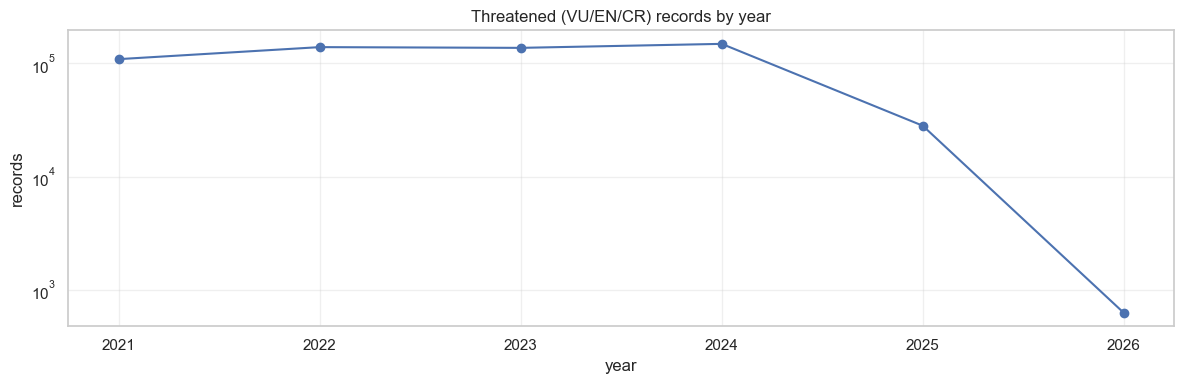

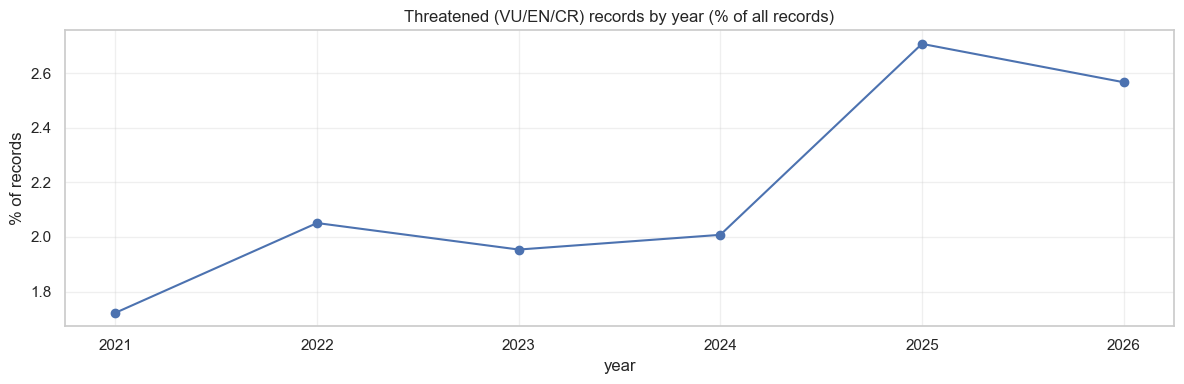

Top threatened taxa (overall):


,iucn_cat,species,records
487,VU,Lanius meridionalis,77804
356,VU,Aythya ferina,64474
479,VU,Ichthyaetus audouinii,61125
584,VU,Streptopelia turtur,53526
266,EN,Neophron percnopterus,37867
536,VU,Pluvialis squatarola,33436
272,EN,Otis tarda,24380
346,VU,Aquila adalberti,23445
274,EN,Pararge aegeria,22958
273,EN,Oxyura leucocephala,21484


Distinct threatened taxa per year:


,year,distinct_threatened_taxa
0,2021,369
1,2022,380
2,2023,398
3,2024,389
4,2025,379
5,2026,88


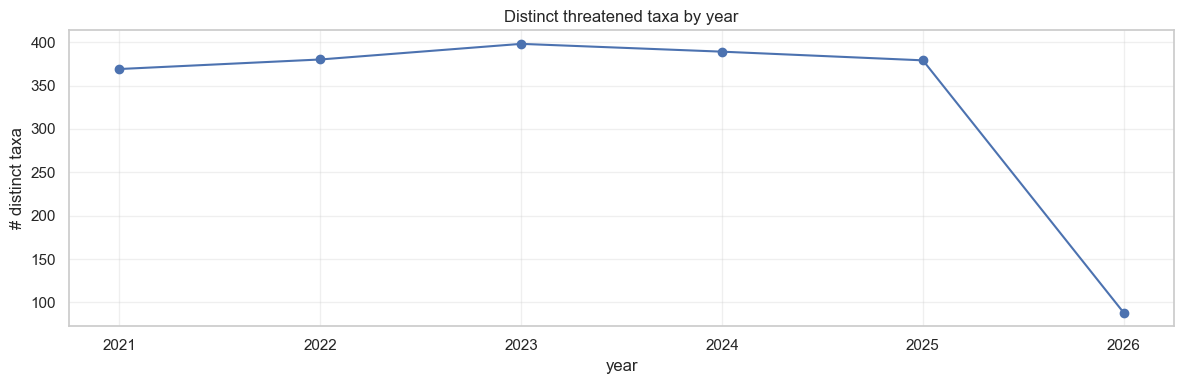

In [10]:
if df_all is None:
    raise RuntimeError("df_all is None. Run the optional in-memory load cell with LOAD_IN_MEMORY=True.")

# is_threatened and iucn_cat come from the search API join cell above (run that first)
if "is_threatened" not in df_all.columns or "iucn_cat" not in df_all.columns:
    raise ValueError("Run the previous cell to fetch threatened species via search API and join to df_all.")

SPECIES_COL = "species" if "species" in df_all.columns else ("scientificName" if "scientificName" in df_all.columns else None)
if SPECIES_COL is None:
    raise ValueError("df_all must contain either 'species' or 'scientificName'")

THREATENED = {"VU", "EN", "CR"}
df_th = df_all[df_all["is_threatened"]].copy()

print("Threatened categories used:", sorted(THREATENED))
print("Threatened records:", len(df_th), "/", len(df_all), f"({(len(df_th)/len(df_all)*100 if len(df_all) else 0):.4f}%)")
print("Threatened category breakdown:")
display(df_th["iucn_cat"].value_counts(dropna=False))

# Per year counts + %
by_year_all = df_all.groupby("year").size().rename("all_records")
by_year_th = df_th.groupby("year").size().rename("threatened_records")
by_year = pd.concat([by_year_all, by_year_th], axis=1).fillna(0).reset_index()
by_year["pct_threatened"] = (by_year["threatened_records"] / by_year["all_records"] * 100).round(4)
by_year = by_year.sort_values("year")

display(by_year)

plt.figure(figsize=(12, 4))
plt.plot(by_year["year"], by_year["threatened_records"], marker="o")
plt.title("Threatened (VU/EN/CR) records by year")
plt.xlabel("year")
plt.ylabel("records")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(by_year["year"], by_year["pct_threatened"], marker="o")
plt.title("Threatened (VU/EN/CR) records by year (% of all records)")
plt.xlabel("year")
plt.ylabel("% of records")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Top threatened species (overall)
top_species = (
    df_th.groupby(["iucn_cat", SPECIES_COL])
    .size()
    .rename("records")
    .reset_index()
    .sort_values("records", ascending=False)
)
print("Top threatened taxa (overall):")
display(top_species.head(30))

# Distinct threatened taxa per year
rich = (
    df_th.groupby("year")[SPECIES_COL]
    .nunique(dropna=True)
    .rename("distinct_threatened_taxa")
    .reset_index()
    .sort_values("year")
)
print("Distinct threatened taxa per year:")
display(rich)

plt.figure(figsize=(12, 4))
plt.plot(rich["year"], rich["distinct_threatened_taxa"], marker="o")
plt.title("Distinct threatened taxa by year")
plt.xlabel("year")
plt.ylabel("# distinct taxa")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# Folium map: threatened species (VU/EN/CR) in Spain, year=2024 (cap 30k)

import folium

MAP_YEAR = 2024
CAP = 30_000

need_cols = ["decimalLatitude", "decimalLongitude", "year", SPECIES_COL, "iucn_cat"]
for c in need_cols:
    if c not in df_th.columns:
        raise ValueError(f"Missing required column in df_th: {c}")

pts = df_th[need_cols].copy()
pts["year"] = pd.to_numeric(pts["year"], errors="coerce").astype("Int64")
pts = pts[pts["year"] == MAP_YEAR].copy()

pts["decimalLatitude"] = pd.to_numeric(pts["decimalLatitude"], errors="coerce")
pts["decimalLongitude"] = pd.to_numeric(pts["decimalLongitude"], errors="coerce")
pts = pts.dropna(subset=["decimalLatitude", "decimalLongitude"])

print("Threatened points (pre-sample):", len(pts))

if len(pts) == 0:
    raise ValueError(f"No threatened records with coordinates for year={MAP_YEAR}")

# Proportional stratified sampling across IUCN categories (and keep cities/other balanced implicitly)
cat_counts = pts["iucn_cat"].value_counts()
alloc = (cat_counts / cat_counts.sum() * CAP).round().astype(int)
alloc[alloc < 1] = 1
alloc = pd.concat([alloc, cat_counts], axis=1)
alloc.columns = ["n_alloc", "n_available"]
alloc["n_alloc"] = alloc[["n_alloc", "n_available"]].min(axis=1).astype(int)

# Adjust to match CAP (best effort)
diff = int(CAP - alloc["n_alloc"].sum())
if diff != 0:
    if diff > 0:
        candidates = alloc[alloc["n_alloc"] < alloc["n_available"]]
        for k in candidates.index.tolist():
            if diff == 0:
                break
            alloc.loc[k, "n_alloc"] += 1
            diff -= 1
    else:
        candidates = alloc[alloc["n_alloc"] > 1]
        for k in candidates.index.tolist():
            if diff == 0:
                break
            alloc.loc[k, "n_alloc"] -= 1
            diff += 1

print("Sampling plan by IUCN category:")
display(alloc)

parts = []
for cat, row in alloc.iterrows():
    n = int(row["n_alloc"])
    g = pts[pts["iucn_cat"] == cat]
    if n >= len(g):
        parts.append(g)
    else:
        parts.append(g.sample(n=n, random_state=42))

sampled = pd.concat(parts, ignore_index=True)
print("Sampled points:", len(sampled))

# Map
m = folium.Map(location=[40.2, -3.5], zoom_start=6, tiles="cartodbpositron")

color_by_cat = {"VU": "#ff7f0e", "EN": "#d62728", "CR": "#9467bd"}

for cat, g in sampled.groupby("iucn_cat"):
    fg = folium.FeatureGroup(name=f"{cat} ({len(g)})")
    color = color_by_cat.get(cat, "blue")

    for row in g.itertuples(index=False):
        sp = getattr(row, SPECIES_COL)
        sp = str(sp) if sp is not None else ""
        folium.CircleMarker(
            location=[row.decimalLatitude, row.decimalLongitude],
            radius=2,
            color=color,
            fill=True,
            fill_opacity=0.7,
            weight=0,
            tooltip=f"{cat} | year={int(row.year)} | {sp}",
        ).add_to(fg)

    fg.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

out_map = Path("pictures") / f"spain_threatened_map_year{MAP_YEAR}_cap{CAP}.html"
out_map.parent.mkdir(exist_ok=True)
m.save(out_map)

print("Saved map:", out_map)
out_map

Threatened points (pre-sample): 148854
Sampling plan by IUCN category:


,n_alloc,n_available
iucn_cat,,
VU,21244,105409
EN,7208,35763
CR,1548,7682


Sampled points: 30000
Saved map: pictures/spain_threatened_map_year2024_cap30000.html


PosixPath('pictures/spain_threatened_map_year2024_cap30000.html')